In [11]:
import random
from rich.table import Table
from rich.console import Console

# SMALL (2-10 vehicles, 10-20 customers)
small = {
    'scenario_1': {
        'name': 'Dense Cluster',
        'locations': [(0, 0), (5, 8), (12, 3), (8, 15), (20, 7), (3, 12), (18, 5), (6, 20), (15, 12), (9, 4), 
                      (22, 18), (4, 16), (17, 9), (11, 22), (25, 3), (7, 11)],  
        'num_vehicles': 5,
        'population_size': 50
    },
    'scenario_2': {
        'name': 'Spread Pattern',
        'locations': [(0, 0), (8, 6), (15, 12), (3, 18), (22, 4), (11, 20), (6, 9), (19, 15), (4, 11), (16, 7),
                      (12, 25), (9, 13), (24, 8), (2, 22), (18, 18), (14, 5), (10, 16), (21, 11), (7, 19)],  
        'num_vehicles': 8,
        'population_size': 50
    }
}

# GENETIC ALGORITHM PARAMETERS - As required by professor
# Test 3 different parameter combinations for each scenario

GA_PARAMETERS = {
    'set_1': {
        'name': 'Conservative',
        'population_size': 30,
        'generations': 50,
        'crossover_rate': 0.7,
        'mutation_rate': 0.1,
        'description': 'Small pop, moderate generations, low mutation'
    },
    'set_2': {
        'name': 'Balanced',
        'population_size': 50,
        'generations': 100,
        'crossover_rate': 0.8,
        'mutation_rate': 0.2,
        'description': 'Medium pop, high generations, balanced rates'
    },
    'set_3': {
        'name': 'Aggressive',
        'population_size': 80,
        'generations': 75,
        'crossover_rate': 0.9,
        'mutation_rate': 0.3,
        'description': 'Large pop, moderate generations, high mutation'
    }
}

# Display parameter sets
print(" GENETIC ALGORITHM PARAMETER SETS:")
print("=" * 60)
for key, params in GA_PARAMETERS.items():
    print(f"{key.upper()} - {params['name']}:")
    print(f"  Population: {params['population_size']}")
    print(f"  Generations: {params['generations']}")
    print(f"  Crossover Rate: {params['crossover_rate']}")
    print(f"  Mutation Rate: {params['mutation_rate']}")
    print(f"  Strategy: {params['description']}")
    print()

 GENETIC ALGORITHM PARAMETER SETS:
SET_1 - Conservative:
  Population: 30
  Generations: 50
  Crossover Rate: 0.7
  Mutation Rate: 0.1
  Strategy: Small pop, moderate generations, low mutation

SET_2 - Balanced:
  Population: 50
  Generations: 100
  Crossover Rate: 0.8
  Mutation Rate: 0.2
  Strategy: Medium pop, high generations, balanced rates

SET_3 - Aggressive:
  Population: 80
  Generations: 75
  Crossover Rate: 0.9
  Mutation Rate: 0.3
  Strategy: Large pop, moderate generations, high mutation



# Vehicle Routing Problem (VRP) - Genetic Algorithm Implementation

## Project Setup and Configuration

This section defines the problem scenarios and genetic algorithm parameters for the VRP optimization study. We implement two distinct customer distribution patterns with different vehicle requirements to test the genetic algorithm's adaptability.


In [12]:

SCENARIOS = [small['scenario_1'], small['scenario_2']]  # Both scenarios

# Display both scenarios
print("SMALL SCENARIOS:")
for i, scenario in enumerate(SCENARIOS, 1):
    print(f"{i}. {scenario['name']}: {len(scenario['locations'])-1} customers, {scenario['num_vehicles']} vehicles")

def create_individual(scenario):
    """Create individual chromosome for a specific scenario with better route distribution"""
    locations = scenario['locations']
    customers = list(range(1, len(locations)))
    num_vehicles = scenario['num_vehicles']
    
    # Shuffle customers randomly
    random.shuffle(customers)
    
    # Create better distributed routes by inserting separators more evenly
    # Calculate approximate customers per vehicle
    customers_per_vehicle = len(customers) / num_vehicles
    
    chromosome = []
    separator_positions = []
    
    # Insert separators at approximate intervals
    for i in range(num_vehicles - 1):
        pos = int((i + 1) * customers_per_vehicle)
        # Add some randomness to avoid too rigid structure
        pos += random.randint(-1, 1) if i > 0 and i < num_vehicles - 2 else 0
        pos = max(1, min(pos, len(customers) - 1))  # Keep within bounds
        separator_positions.append(pos)
    
    # Remove duplicates and sort
    separator_positions = sorted(list(set(separator_positions)))
    
    # Build chromosome with customers and separators
    customer_idx = 0
    sep_idx = 0
    
    for i in range(len(customers) + len(separator_positions)):
        if sep_idx < len(separator_positions) and customer_idx == separator_positions[sep_idx]:
            chromosome.append(0)  # Add separator
            sep_idx += 1
        else:
            if customer_idx < len(customers):
                chromosome.append(customers[customer_idx])
                customer_idx += 1
    
    # Add any remaining customers
    while customer_idx < len(customers):
        chromosome.append(customers[customer_idx])
        customer_idx += 1
    
    # Add any remaining separators at the end
    while len([x for x in chromosome if x == 0]) < num_vehicles - 1:
        chromosome.append(0)
    
    return chromosome


SMALL SCENARIOS:
1. Dense Cluster: 15 customers, 5 vehicles
2. Spread Pattern: 18 customers, 8 vehicles


## Chromosome Representation and Individual Creation

**Key Innovation:** Our chromosome uses customer genes (1-n) and separator genes (0s) to represent vehicle routes.

**Example:** `[3, 1, 0, 5, 2, 0, 4]` represents:

- Vehicle 1: visits customers 3, 1
- Vehicle 2: visits customers 5, 2
- Vehicle 3: visits customer 4

**Improvement:** Enhanced chromosome generation creates better initial route distribution to prevent all customers being assigned to a single vehicle.


## Fitness and Distance Calculation Functions

**Core VRP Functions:**

- **`parse_routes()`** - Helper function that converts chromosomes to route lists
- **`calculate_total_distance()`** - Computes euclidean distance for all vehicle routes
- **`fitness()`** - Converts distance to fitness with vehicle utilization penalties
- **`visualize_routes()`** - Formats solutions for readable output

**Key Innovation:** Penalty system encourages multi-vehicle solutions by penalizing chromosomes that use fewer than 70% of available vehicles, preventing the algorithm from converging to unrealistic single-vehicle routes.


In [13]:
def parse_routes(individual):
    """Helper function: Convert chromosome to list of routes"""
    routes = []
    current_route = []
    
    for gene in individual:
        if gene == 0:
            routes.append(current_route)
            current_route = []
        elif gene != 0:
            current_route.append(gene)
    
    if current_route:
        routes.append(current_route)
    
    # Remove empty routes
    return [route for route in routes if route]

def calculate_total_distance(individual, locations):
    """Calculate total distance for VRP solution"""
    routes = parse_routes(individual)
    
    total_distance = 0
    for route in routes:
        prev = 0  # start at depot
        for customer in route:
            loc1 = locations[prev]
            loc2 = locations[customer]
            total_distance += ((loc1[0] - loc2[0])**2 + (loc1[1] - loc2[1])**2)**0.5
            prev = customer
        # return to depot
        loc1 = locations[prev]
        loc2 = locations[0]
        total_distance += ((loc1[0] - loc2[0])**2 + (loc1[1] - loc2[1])**2)**0.5
    
    return total_distance

def fitness(individual, locations, expected_vehicles=None):
    """Calculate fitness for VRP with penalty for not using enough vehicles"""
    total_distance = calculate_total_distance(individual, locations)
    
    if total_distance == 0:
        return 0
    
    # Apply penalty for not using enough vehicles
    if expected_vehicles:
        routes = parse_routes(individual)
        if len(routes) < expected_vehicles * 0.70:  # Less than 70% of vehicles
            unused_vehicles = expected_vehicles - len(routes)
            penalty_factor = 1 + (unused_vehicles * 0.5)  # 50% penalty per unused vehicle
            total_distance *= penalty_factor
    
    return 1 / total_distance

def visualize_routes(individual):
    """Convert individual chromosome to readable route format"""
    routes = parse_routes(individual)
    
    route_strings = []
    for i, route in enumerate(routes, 1):
        route_str = " -> ".join([str(0)] + [str(c) for c in route] + [str(0)])
        route_strings.append(f"Vehicle {i}: {route_str}")
    
    return "\n    ".join(route_strings)


## Crossover Function

**Key Terms:**

- **Parent1 and Parent2:** Two full delivery plans (solutions)
- **Child:** A new delivery plan created by mixing the parents
- **Route:** The list of stops for one driver, found by splitting a plan at the separators (0s)

**Crossover:**

1. **Copy a slice from parent1** - preserves some structure from the first parent
2. **Fill remaining spots with parent2 genes in order** - ensures all customers and separators are included without duplication
3. **No post-processing needed** - the logic naturally prevents invalid solutions


In [14]:
def vrp_crossover(parent1, parent2):
    """
    VRP-specific crossover that preserves chromosome structure.
    Uses order crossover (OX) adapted for VRP with separators.
    """
    # Step 1: Select a random sub-section from parent1
    start, end = sorted(random.sample(range(len(parent1)), 2))
    child = [None] * len(parent1)
    
    # Step 2: Copy the selected section from parent1 to child
    child[start:end] = parent1[start:end]
    
    # Step 3: Create a list of remaining genes from parent2 (in order)
    used_genes = set(parent1[start:end])
    remaining_genes = [gene for gene in parent2 if gene not in used_genes]
    
    # Step 4: Fill the empty positions with remaining genes
    remaining_index = 0
    for i in range(len(child)):
        if child[i] is None and remaining_index < len(remaining_genes):
            child[i] = remaining_genes[remaining_index]
            remaining_index += 1
    
    # Step 5: Final safety check - replace any remaining None values
    for i in range(len(child)):
        if child[i] is None:
            # Find any missing gene that should be in the chromosome
            all_genes = set(parent1)
            used_in_child = set([g for g in child if g is not None])
            missing = all_genes - used_in_child
            if missing:
                child[i] = missing.pop()
            else:
                child[i] = 0  # fallback to separator
    
    return child

## Crossover Implementation

**Order Crossover (OX) Adapted for VRP:**

The crossover operation creates new solutions by combining parent chromosomes while preserving the essential structure of customer assignments and vehicle separators.


In [15]:
def vrp_mutate(individual, mutation_rate=0.1):
    """VRP mutation: swap two customers (not separators) based on mutation rate"""
    if random.random() < mutation_rate:
        # Find all customer gene positions (not separators)
        customer_positions = [i for i, gene in enumerate(individual) if gene != 0]
        
        # Only mutate if we have at least 2 customers to swap
        if len(customer_positions) >= 2:
            i, j = random.sample(customer_positions, 2)
            individual[i], individual[j] = individual[j], individual[i]
    
    return individual

## Mutation and Selection Operations

**VRP Mutation:** Swaps customer positions (never separators) to explore route variations while maintaining chromosome integrity.

**Tournament Selection:** Selects the best individuals from random tournaments to guide evolution toward optimal solutions.


In [16]:
def tournament_selection(population, locations, expected_vehicles=None, tournament_size=3):
    """Tournament selection - select best individual from random tournament"""
    tournament = random.sample(population, min(tournament_size, len(population)))
    return max(tournament, key=lambda ind: fitness(ind, locations, expected_vehicles))

def create_population(scenario, population_size):
    """Create initial population for genetic algorithm"""
    population = []
    for _ in range(population_size):
        individual = create_individual(scenario)
        population.append(individual)
    return population

In [17]:
def genetic_algorithm(scenario, ga_params):
    import time
    start_time = time.time()
    
    # Extract parameters
    pop_size = ga_params['population_size']
    generations = ga_params['generations'] 
    crossover_rate = ga_params['crossover_rate']
    mutation_rate = ga_params['mutation_rate']
    locations = scenario['locations']
    expected_vehicles = scenario['num_vehicles']
    
    # Create initial population
    population = create_population(scenario, pop_size)
    
    # Track best solutions over generations
    best_distances = []
    generation_stats = []
    
    print(f"Running GA: {ga_params['name']} on {scenario['name']}")
    print(f"   Pop: {pop_size}, Gen: {generations}, Cross: {crossover_rate}, Mut: {mutation_rate}")
    
    for gen in range(generations):
        # Evaluate fitness for all individuals (pass expected_vehicles for penalty)
        fitnesses = [fitness(ind, locations, expected_vehicles) for ind in population]
        distances = [calculate_total_distance(ind, locations) for ind in population]
        
        # Track best solution this generation
        best_idx = max(range(len(fitnesses)), key=lambda i: fitnesses[i])
        best_distance = distances[best_idx]
        best_distances.append(best_distance)
        
        # Statistics for this generation
        avg_distance = sum(distances) / len(distances)
        generation_stats.append({
            'generation': gen,
            'best_distance': best_distance,
            'avg_distance': avg_distance,
            'best_individual': population[best_idx].copy()
        })
        
        # Print progress every 25 generations (reduced output)
        if gen % 25 == 0 or gen == generations - 1:
            print(f"   Gen {gen:3d}: Best = {best_distance:.2f}")
        
        # Create new population (except for last generation)
        if gen < generations - 1:
            new_population = []
            
            # Elitism: Keep best individual
            new_population.append(population[best_idx].copy())
            
            # Generate rest of population
            while len(new_population) < pop_size:
                # Selection (pass expected_vehicles for penalty)
                parent1 = tournament_selection(population, locations, expected_vehicles)
                parent2 = tournament_selection(population, locations, expected_vehicles)
                
                # Crossover
                if random.random() < crossover_rate:
                    child = vrp_crossover(parent1, parent2)
                else:
                    child = parent1.copy()
                
                # Mutation
                child = vrp_mutate(child, mutation_rate)
                
                new_population.append(child)
            
            population = new_population
    
    # Calculate execution time
    end_time = time.time()
    execution_time = end_time - start_time
    
    # Return best solution found
    final_best = generation_stats[-1]
    final_best['execution_time'] = execution_time
    print(f"Complete! Best distance: {final_best['best_distance']:.2f}, Time: {execution_time:.2f}s")
    
    return final_best, generation_stats, best_distances

## Main Genetic Algorithm Engine

This is the core evolutionary loop that drives the optimization process. It combines all genetic operations (selection, crossover, mutation) with elitism to continuously improve solutions over generations.

**Key Features:**

- Tracks best solutions across generations
- Implements elitism (keeps best individual)
- Provides progress reporting
- Handles vehicle utilization penalties


In [18]:
def run_multiple_trials(scenario, ga_params, num_trials=10):
    """
    Run genetic algorithm multiple times to collect statistical data
    Returns best-of-run statistics for proper GA analysis
    """
    print(f"\nRunning {num_trials} trials for {ga_params['name']} on {scenario['name']}")
    
    best_of_run_distances = []
    execution_times = []
    all_trial_results = []
    
    for trial in range(num_trials):
        print(f"  Trial {trial + 1}/{num_trials}...", end=" ")
        
        # Run single genetic algorithm trial
        best_solution, stats, distances = genetic_algorithm(scenario, ga_params)
        
        # Collect the best distance from this run
        best_of_run_distances.append(best_solution['best_distance'])
        execution_times.append(best_solution['execution_time'])
        all_trial_results.append({
            'trial': trial + 1,
            'best_distance': best_solution['best_distance'],
            'execution_time': best_solution['execution_time'],
            'best_individual': best_solution['best_individual']
        })
        
        print(f"Best: {best_solution['best_distance']:.2f}, Time: {best_solution['execution_time']:.2f}s")
    
    # Calculate statistics across all trials
    overall_best = min(best_of_run_distances)
    overall_worst = max(best_of_run_distances)
    average_best = sum(best_of_run_distances) / len(best_of_run_distances)
    average_time = sum(execution_times) / len(execution_times)
    total_time = sum(execution_times)
    
    # Find the trial that achieved the overall best
    best_trial_idx = best_of_run_distances.index(overall_best)
    best_trial_solution = all_trial_results[best_trial_idx]['best_individual']
    
    statistics = {
        'num_trials': num_trials,
        'best_of_run_distances': best_of_run_distances,
        'execution_times': execution_times,
        'overall_best': overall_best,
        'overall_worst': overall_worst,
        'average_best': average_best,
        'average_time': average_time,
        'total_time': total_time,
        'best_trial_solution': best_trial_solution,
        'all_trials': all_trial_results
    }
    
    print(f"  Statistics: Best={overall_best:.2f}, Avg={average_best:.2f}, Time={average_time:.2f}s")
    return statistics

def run_comprehensive_experiment(num_trials=10):
    """
    Run the complete statistical analysis with multiple trials per configuration
    This provides the rigorous analysis expected in GA research
    """
    console = Console()
    all_results = {}
    
    console.print(f"\n[bold green]COMPREHENSIVE GENETIC ALGORITHM ANALYSIS[/bold green]")
    console.print(f"[bold blue]Running {num_trials} trials × 3 parameter sets × 2 scenarios = {num_trials * 6} total GA runs[/bold blue]")
    console.print("=" * 80)
    
    # Run all combinations with multiple trials
    for param_key, ga_params in GA_PARAMETERS.items():
        console.print(f"\n[bold yellow]PARAMETER SET: {param_key.upper()} - {ga_params['name']}[/bold yellow]")
        
        for scenario in SCENARIOS:
            console.print(f"\n[cyan]Testing on {scenario['name']}...[/cyan]")
            
            # Run multiple trials and collect statistics
            statistics = run_multiple_trials(scenario, ga_params, num_trials)
            
            # Store comprehensive results
            key = f"{param_key}_{scenario['name'].replace(' ', '_').lower()}"
            all_results[key] = {
                'param_set': param_key,
                'scenario': scenario['name'],
                'ga_params': ga_params,
                'statistics': statistics
            }
            
            console.print("=" * 50)
    
    return all_results

def display_comprehensive_summary(results):
    """Display comprehensive statistical summary"""
    console = Console()
    
    # Create detailed statistical table
    table = Table(title="COMPREHENSIVE GA STATISTICAL ANALYSIS")
    table.add_column("Parameter Set", style="cyan", no_wrap=True)
    table.add_column("Scenario", style="blue", no_wrap=True)
    table.add_column("Best Distance", style="green", justify="right")
    table.add_column("Average±Std", style="magenta", justify="right")
    table.add_column("Avg Time (s)", style="yellow", justify="right")
    table.add_column("Total Time (s)", style="red", justify="right")
    table.add_column("Trials", style="white", justify="center")
    table.add_column("Status", style="bold red")
    
    # Find overall best for each scenario across all parameter sets
    scenario_bests = {}
    for key, result in results.items():
        scenario = result['scenario']
        best_distance = result['statistics']['overall_best']
        if scenario not in scenario_bests or best_distance < scenario_bests[scenario]['distance']:
            scenario_bests[scenario] = {'distance': best_distance, 'key': key}
    
    # Add rows with statistical data
    for key, result in results.items():
        stats = result['statistics']
        is_best = key == scenario_bests[result['scenario']]['key']
        status = "BEST" if is_best else ""
        style = "bold red" if is_best else None
        
        # Calculate standard deviation
        distances = stats['best_of_run_distances']
        mean = stats['average_best']
        variance = sum((x - mean) ** 2 for x in distances) / len(distances)
        std_dev = variance ** 0.5
        
        table.add_row(
            result['param_set'].replace('_', ' ').title(),
            result['scenario'],
            f"{stats['overall_best']:.2f}",
            f"{stats['average_best']:.2f}±{std_dev:.2f}",
            f"{stats['average_time']:.2f}",
            f"{stats['total_time']:.2f}",
            str(stats['num_trials']),
            status,
            style=style
        )
    
    console.print(table)
    
    # Show best solutions with statistical context
    console.print(f"\n[bold green]STATISTICAL ANALYSIS RESULTS:[/bold green]")
    for scenario, best_info in scenario_bests.items():
        result = results[best_info['key']]
        stats = result['statistics']
        console.print(f"[bold blue]{scenario}:[/bold blue]")
        console.print(f"   Best Distance: {stats['overall_best']:.2f} units")
        console.print(f"   Average: {stats['average_best']:.2f} units")
        console.print(f"   Consistency: {stats['overall_worst'] - stats['overall_best']:.2f} unit spread")
        console.print(f"   Parameter Set: {result['param_set']} ({result['ga_params']['name']})")
        console.print(f"   Routes: {visualize_routes(stats['best_trial_solution'])}")
        console.print()

def display_time_summary(results):
    """Display dedicated time summary table as required by professor"""
    console = Console()
    
    # Create time summary table
    table = Table(title="COMPUTATIONAL TIME SUMMARY TABLE")
    table.add_column("Parameter Set", style="cyan", no_wrap=True)
    table.add_column("Scenario", style="blue", no_wrap=True)
    table.add_column("Population Size", style="green", justify="center")
    table.add_column("Generations", style="green", justify="center")
    table.add_column("Avg Time per Trial (s)", style="yellow", justify="right")
    table.add_column("Total Time (s)", style="red", justify="right")
    table.add_column("Trials", style="white", justify="center")
    table.add_column("Time per Generation (s)", style="magenta", justify="right")
    
    total_computation_time = 0
    
    # Add rows for each configuration
    for key, result in results.items():
        stats = result['statistics']
        ga_params = result['ga_params']
        time_per_generation = stats['average_time'] / ga_params['generations']
        total_computation_time += stats['total_time']
        
        table.add_row(
            result['param_set'].replace('_', ' ').title(),
            result['scenario'],
            str(ga_params['population_size']),
            str(ga_params['generations']),
            f"{stats['average_time']:.2f}",
            f"{stats['total_time']:.2f}",
            str(stats['num_trials']),
            f"{time_per_generation:.3f}"
        )
    
    console.print(table)
    console.print(f"\n[bold green]TOTAL EXPERIMENTAL TIME: {total_computation_time:.2f} seconds ({total_computation_time/60:.1f} minutes)[/bold green]")
    
    # Performance analysis
    console.print(f"\n[bold blue]COMPUTATIONAL PERFORMANCE ANALYSIS:[/bold blue]")
    
    # Find fastest and slowest configurations
    fastest_config = min(results.items(), key=lambda x: x[1]['statistics']['average_time'])
    slowest_config = max(results.items(), key=lambda x: x[1]['statistics']['average_time'])
    
    console.print(f"• [green]Fastest Configuration:[/green] {fastest_config[1]['param_set']} on {fastest_config[1]['scenario']}")
    console.print(f"  Average time: {fastest_config[1]['statistics']['average_time']:.2f}s per trial")
    console.print(f"• [red]Slowest Configuration:[/red] {slowest_config[1]['param_set']} on {slowest_config[1]['scenario']}")
    console.print(f"  Average time: {slowest_config[1]['statistics']['average_time']:.2f}s per trial")
    console.print(f"• [yellow]Speed Difference:[/yellow] {slowest_config[1]['statistics']['average_time'] / fastest_config[1]['statistics']['average_time']:.1f}x slower")

print("COMPREHENSIVE GENETIC ALGORITHM ANALYSIS:")
print("• 10 trials per configuration for proper statistical analysis")
print("• 3 parameter sets × 2 scenarios × 10 trials = 60 total GA runs")
print("• Provides best-of-run statistics as required for GA research")
print("• Includes computational time tracking for performance analysis")
print("Run the cell below to execute the complete statistical analysis.")

COMPREHENSIVE GENETIC ALGORITHM ANALYSIS:
• 10 trials per configuration for proper statistical analysis
• 3 parameter sets × 2 scenarios × 10 trials = 60 total GA runs
• Provides best-of-run statistics as required for GA research
• Includes computational time tracking for performance analysis
Run the cell below to execute the complete statistical analysis.


## Experiment Management and Results Analysis

**Professor Requirement Fulfilled:** These functions execute the complete experimental design with 3 different parameter sets tested on 2 scenarios (6 total experiments).

**Professional Presentation:** Results are displayed using Rich library for formatted tables with color-coded best solutions and comprehensive statistics.


# ASSIGNMENT EXECUTION - RUN THE FULL EXPERIMENT

**This cell runs the complete VRP genetic algorithm experiment as required:**

- **3 different parameter sets** (Conservative, Balanced, Aggressive)
- **2 scenarios** (Dense Cluster, Spread Pattern)
- **Total: 6 experiments** with professional results table
- **Professor confirmed requirement**: Test different parameters for each dataset

Run the cell below to execute the complete assignment!


In [19]:
# EXECUTE COMPREHENSIVE EXPERIMENT - MULTIPLE TRIALS FOR STATISTICAL ANALYSIS!

# Run the comprehensive statistical analysis (10 trials × 3 parameter sets × 2 scenarios = 60 total runs)
# This provides the "best-of-run" statistics your professor wants
results = run_comprehensive_experiment(10)  # 10 trials per configuration

# Display the comprehensive statistical summary with best-of-run analysis
display_comprehensive_summary(results)

# Display the computational time summary table as required by professor
display_time_summary(results)

COMPREHENSIVE GENETIC ALGORITHM ANALYSIS

Running 10 trials × 3 parameter sets × 2 scenarios = 60 total GA runs

================================================================================

PARAMETER SET: SET_1 - Conservative

Testing on Dense Cluster...


Running 10 trials for Conservative on Dense Cluster
  Trial 1/10... Running GA: Conservative on Dense Cluster
   Pop: 30, Gen: 50, Cross: 0.7, Mut: 0.1
   Gen   0: Best = 271.80
   Gen  25: Best = 199.03
   Gen  49: Best = 179.71   Gen  49: Best = 179.71
Complete! Best distance: 179.71, Time: 0.21s
Best: 179.71, Time: 0.21s
  Trial 2/10... Running GA: Conservative on Dense Cluster
   Pop: 30, Gen: 50, Cross: 0.7, Mut: 0.1
   Gen   0: Best = 274.15
   Gen  25: Best = 200.84
   Gen  49: Best = 180.98
Complete! Best distance: 180.98, Time: 0.16s
Best: 180.98, Time: 0.16s
  Trial 3/10... Running GA: Conservative on Dense Cluster
   Pop: 30, Gen: 50, Cross: 0.7, Mut: 0.1
   Gen   0: Best = 266.99
   Gen  25: Best = 206.21

Complete! Best distance: 179.71, Time: 0.21s
Best: 179.71, Time: 0.21s
  Trial 2/10... Running GA: Conservative on Dense Cluster
   Pop: 30, Gen: 50, Cross: 0.7, Mut: 0.1
   Gen   0: Best = 274.15
   Gen  25: Best = 200.84
   Gen  49: Best = 180.98
Complete! Best distanc

==================================================

Testing on Spread Pattern...


Running 10 trials for Conservative on Spread Pattern
  Trial 1/10... Running GA: Conservative on Spread Pattern
   Pop: 30, Gen: 50, Cross: 0.7, Mut: 0.1
   Gen   0: Best = 380.95
   Gen  25: Best = 321.92
   Gen  49: Best = 267.83
Complete! Best distance: 267.83, Time: 0.21s
Best: 267.83, Time: 0.21s
  Trial 2/10... Running GA: Conservative on Spread Pattern
   Pop: 30, Gen: 50, Cross: 0.7, Mut: 0.1
   Gen   0: Best = 389.99
   Gen  49: Best = 267.83
Complete! Best distance: 267.83, Time: 0.21s
Best: 267.83, Time: 0.21s
  Trial 2/10... Running GA: Conservative on Spread Pattern
   Pop: 30, Gen: 50, Cross: 0.7, Mut: 0.1
   Gen   0: Best = 389.99
   Gen  25: Best = 338.67
   Gen  49: Best = 321.88
Complete! Best distance: 321.88, Time: 0.20s
Best: 321.88, Time: 0.20s
  Trial 3/10... Running GA: Conservative on Spread Pattern
   Pop: 30, Gen: 50, Cross: 0.7, Mut: 0.1
   Gen   0: Best = 375.69
   Gen  25: Best = 338.67
   Gen  49: Best = 321.88
Complete! Best distance: 321.88, Time: 0.20

==================================================

PARAMETER SET: SET_2 - Balanced

Testing on Dense Cluster...


Running 10 trials for Balanced on Dense Cluster
  Trial 1/10... Running GA: Balanced on Dense Cluster
   Pop: 50, Gen: 100, Cross: 0.8, Mut: 0.2
   Gen   0: Best = 250.53
   Gen  25: Best = 204.33
   Gen  50: Best = 191.73   Gen  50: Best = 191.73
   Gen  75: Best = 178.73

   Gen  75: Best = 178.73
   Gen  99: Best = 174.84
Complete! Best distance: 174.84, Time: 0.60s
Best: 174.84, Time: 0.60s
  Trial 2/10... Running GA: Balanced on Dense Cluster
   Pop: 50, Gen: 100, Cross: 0.8, Mut: 0.2
   Gen   0: Best = 278.83
   Gen  25: Best = 192.85
   Gen  99: Best = 174.84
Complete! Best distance: 174.84, Time: 0.60s
Best: 174.84, Time: 0.60s
  Trial 2/10... Running GA: Balanced on Dense Cluster
   Pop: 50, Gen: 100, Cross: 0.8, Mut: 0.2
   Gen   0: Best = 278.83
   Gen  25: Best = 192.85
   Gen  50: Best = 177.05
   Gen  75: Best = 177.05
   Gen  50: Best = 177.05
   Gen  75: Best = 177.05
   Gen  99: Best = 172.02
Complete! Best distance: 172.02, Time: 0.61s
Best: 172.02, Time: 0.61s
  Tri

==================================================

Testing on Spread Pattern...


Running 10 trials for Balanced on Spread Pattern
  Trial 1/10... Running GA: Balanced on Spread Pattern
   Pop: 50, Gen: 100, Cross: 0.8, Mut: 0.2
   Gen   0: Best = 377.75
   Gen  25: Best = 308.78
   Gen  50: Best = 294.48
   Gen  50: Best = 294.48
   Gen  75: Best = 280.47
   Gen  99: Best = 269.02
Complete! Best distance: 269.02, Time: 0.79s
Best: 269.02, Time: 0.79s
  Trial 2/10... Running GA: Balanced on Spread Pattern
   Pop: 50, Gen: 100, Cross: 0.8, Mut: 0.2
   Gen   0: Best = 339.65
   Gen  75: Best = 280.47
   Gen  99: Best = 269.02
Complete! Best distance: 269.02, Time: 0.79s
Best: 269.02, Time: 0.79s
  Trial 2/10... Running GA: Balanced on Spread Pattern
   Pop: 50, Gen: 100, Cross: 0.8, Mut: 0.2
   Gen   0: Best = 339.65
   Gen  25: Best = 289.77
   Gen  50: Best = 271.02
   Gen  25: Best = 289.77
   Gen  50: Best = 271.02
   Gen  75: Best = 251.29
   Gen  99: Best = 239.06
Complete! Best distance: 239.06, Time: 0.71s
Best: 239.06, Time: 0.71s
  Trial 3/10... Running GA:

==================================================

PARAMETER SET: SET_3 - Aggressive

Testing on Dense Cluster...


Running 10 trials for Aggressive on Dense Cluster
  Trial 1/10... Running GA: Aggressive on Dense Cluster
   Pop: 80, Gen: 75, Cross: 0.9, Mut: 0.3
   Gen   0: Best = 255.79
   Gen  25: Best = 195.58
   Gen  25: Best = 195.58
   Gen  50: Best = 180.98
   Gen  74: Best = 175.58
Complete! Best distance: 175.58, Time: 0.70s
Best: 175.58, Time: 0.70s
  Trial 2/10... Running GA: Aggressive on Dense Cluster
   Pop: 80, Gen: 75, Cross: 0.9, Mut: 0.3
   Gen   0: Best = 261.77
   Gen  50: Best = 180.98
   Gen  74: Best = 175.58
Complete! Best distance: 175.58, Time: 0.70s
Best: 175.58, Time: 0.70s
  Trial 2/10... Running GA: Aggressive on Dense Cluster
   Pop: 80, Gen: 75, Cross: 0.9, Mut: 0.3
   Gen   0: Best = 261.77
   Gen  25: Best = 178.78
   Gen  50: Best = 158.40
   Gen  25: Best = 178.78
   Gen  50: Best = 158.40
   Gen  74: Best = 158.40
Complete! Best distance: 158.40, Time: 0.70s
Best: 158.40, Time: 0.70s
  Trial 3/10... Running GA: Aggressive on Dense Cluster
   Pop: 80, Gen: 75, C

==================================================

Testing on Spread Pattern...


Running 10 trials for Aggressive on Spread Pattern
  Trial 1/10... Running GA: Aggressive on Spread Pattern
   Pop: 80, Gen: 75, Cross: 0.9, Mut: 0.3
   Gen   0: Best = 366.45
   Gen  25: Best = 287.17
   Gen  25: Best = 287.17
   Gen  50: Best = 265.47
   Gen  50: Best = 265.47
   Gen  74: Best = 250.34
Complete! Best distance: 250.34, Time: 0.95s
Best: 250.34, Time: 0.95s
  Trial 2/10... Running GA: Aggressive on Spread Pattern
   Pop: 80, Gen: 75, Cross: 0.9, Mut: 0.3
   Gen   0: Best = 371.96
   Gen  74: Best = 250.34
Complete! Best distance: 250.34, Time: 0.95s
Best: 250.34, Time: 0.95s
  Trial 2/10... Running GA: Aggressive on Spread Pattern
   Pop: 80, Gen: 75, Cross: 0.9, Mut: 0.3
   Gen   0: Best = 371.96
   Gen  25: Best = 258.39
   Gen  25: Best = 258.39
   Gen  50: Best = 244.17
   Gen  50: Best = 244.17
   Gen  74: Best = 237.72
Complete! Best distance: 237.72, Time: 0.90s
Best: 237.72, Time: 0.90s
  Trial 3/10... Running GA: Aggressive on Spread Pattern
   Pop: 80, Gen: 

==================================================

                                       COMPREHENSIVE GA STATISTICAL ANALYSIS                                       
┏━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┓
┃ Parameter Set ┃ Scenario       ┃ Best Distance ┃  Average±Std ┃ Avg Time (s) ┃ Total Time (s) ┃ Trials ┃ Status ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━┩
│ Set 1         │ Dense Cluster  │        173.59 │  188.93±8.77 │         0.17 │           1.73 │   10   │        │
│ Set 1         │ Spread Pattern │        249.23 │ 288.56±21.49 │         0.21 │           2.12 │   10   │        │
│ Set 2         │ Dense Cluster  │        159.98 │  172.69±6.29 │         0.61 │           6.12 │   10   │        │
│ Set 2         │ Spread Pattern │        233.00 │ 248.66±10.71 │         0.75 │           7.52 │   10   │ BEST   │
│ Set 3         │ Dense Cluster  │        158.40 │  165.79±7.66 │         0.72 │           7.16 │   10   │ BEST   │
│ Set 3         │ Spread Pattern │        235.00 │ 255.17±15.28 │         0.94 │           9.43 │   10   │        │
└───────────────┴────────────────┴───────────────┴──────────────┴──────────────┴────────────────┴────────┴────────┘

STATISTICAL ANALYSIS RESULTS:

Dense Cluster:

Best Distance: 158.40 units

Average: 165.79 units

Consistency: 24.12 unit spread

Parameter Set: set_3 (Aggressive)

Routes: Vehicle 1: 0 -> 2 -> 0
    Vehicle 2: 0 -> 1 -> 0
    Vehicle 3: 0 -> 9 -> 0
    Vehicle 4: 0 -> 5 -> 15 -> 3 -> 11 -> 7 -> 13 -> 10 -> 8 -> 12 -> 4 -> 14 -> 6 -> 0

Spread Pattern:

Best Distance: 233.00 units

Average: 248.66 units

Consistency: 36.02 unit spread

Parameter Set: set_2 (Balanced)

Routes: Vehicle 1: 0 -> 5 -> 10 -> 18 -> 13 -> 3 -> 16 -> 2 -> 14 -> 7 -> 17 -> 12 -> 4 -> 9 -> 0
    Vehicle 2: 0 -> 1 -> 0
    Vehicle 3: 0 -> 15 -> 0
    Vehicle 4: 0 -> 8 -> 0
    Vehicle 5: 0 -> 6 -> 0
    Vehicle 6: 0 -> 11 -> 0

                                         COMPUTATIONAL TIME SUMMARY TABLE                                          
┏━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━┓
┃               ┃                ┃              ┃             ┃    Avg Time ┃              ┃        ┃    Time per ┃
┃               ┃                ┃  Population  ┃             ┃   per Trial ┃   Total Time ┃        ┃  Generation ┃
┃ Parameter Set ┃ Scenario       ┃     Size     ┃ Generations ┃         (s) ┃          (s) ┃ Trials ┃         (s) ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━┩
│ Set 1         │ Dense Cluster  │      30      │     50      │        0.17 │         1.73 │   10   │       0.003 │
│ Set 1         │ Spread Pattern │      30      │     50      │        0.21 │         2.12 │   10   │       0.004 │
│ Set 2         │ Dense Cluster  │      50      │     100     │        0.61 │         6.12 │   10   │       0.006 │
│ Set 2         │ Spread Pattern │      50      │     100     │        0.75 │         7.52 │   10   │       0.008 │
│ Set 3         │ Dense Cluster  │      80      │     75      │        0.72 │         7.16 │   10   │       0.010 │
│ Set 3         │ Spread Pattern │      80      │     75      │        0.94 │         9.43 │   10   │       0.013 │
└───────────────┴────────────────┴──────────────┴─────────────┴─────────────┴──────────────┴────────┴─────────────┘

TOTAL EXPERIMENTAL TIME: 34.07 seconds (0.6 minutes)

COMPUTATIONAL PERFORMANCE ANALYSIS:

• Fastest Configuration: set_1 on Dense Cluster

Average time: 0.17s per trial

• Slowest Configuration: set_3 on Spread Pattern

Average time: 0.94s per trial

• Speed Difference: 5.5x slower

In [20]:
import matplotlib.pyplot as plt
import numpy as np

def plot_vrp_routes(individual, locations, scenario_name, colors=None):
    """Plot VRP routes for visualization"""
    # Parse routes from individual
    routes = []
    current_route = []
    for gene in individual:
        if gene == 0 and current_route:
            routes.append(current_route)
            current_route = []
        elif gene != 0:
            current_route.append(gene)
    if current_route:
        routes.append(current_route)
    
    # Default colors for different vehicles
    if colors is None:
        colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
    
    plt.figure(figsize=(10, 8))
    
    # Plot each vehicle route
    for i, route in enumerate(routes):
        color = colors[i % len(colors)]
        
        # Create full route including depot
        full_route = [0] + route + [0]
        x = [locations[j][0] for j in full_route]
        y = [locations[j][1] for j in full_route]
        
        # Plot route line
        plt.plot(x, y, 'o-', color=color, label=f'Vehicle {i+1} ({len(route)} customers)', linewidth=2, markersize=6)
    
    # Plot all locations with labels
    for idx, (cx, cy) in enumerate(locations):
        if idx == 0:
            # Depot - larger red square
            plt.scatter(cx, cy, color='red', s=200, marker='s', zorder=10, edgecolor='black', linewidth=2)
            plt.text(cx, cy-1.5, 'DEPOT', fontsize=12, ha='center', va='top', fontweight='bold')
        else:
            # Customer - black circle
            plt.scatter(cx, cy, color='black', s=100, zorder=8, edgecolor='white', linewidth=1)
            plt.text(cx+0.5, cy+0.5, str(idx), fontsize=10, ha='left', va='bottom')
    
    # Calculate and display total distance
    total_dist = calculate_total_distance(individual, locations)
    
    plt.title(f'VRP Routes - {scenario_name}\nTotal Distance: {total_dist:.2f}', fontsize=14, fontweight='bold')
    plt.xlabel('X Coordinate', fontsize=12)
    plt.ylabel('Y Coordinate', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# Now plot the route analysis with visualizations
def plot_route_analysis():
    """Plot route analysis for both scenarios with visualizations"""
    for i, scenario in enumerate(SCENARIOS, 1):
        print(f"\nVISUAL ROUTE ANALYSIS - SCENARIO {i}")
        individual = create_individual(scenario)
        
        # Show analysis first
        routes, total_dist = analyze_routes(individual, scenario['locations'], scenario['name'])
        
        # Then plot it
        plot_vrp_routes(individual, scenario['locations'], f"{scenario['name']} - Analysis")
        
        print("=" * 80)

# Run visual route analysis - COMMENTED OUT (this creates random solutions for demo only)
# Uncomment the line below if you want to see random route examples:
# plot_route_analysis()

def plot_best_solutions(results):
    """Plot the best solutions found by the genetic algorithm for each scenario"""
    # Find best solution for each scenario
    scenario_bests = {}
    for key, result in results.items():
        scenario = result['scenario']
        # Handle both comprehensive and quick experiment result formats
        if 'statistics' in result:
            # Comprehensive experiment format
            distance = result['statistics']['overall_best']
            individual = result['statistics']['best_trial_solution']
        else:
            # Quick experiment format (fallback)
            distance = result['best_distance']
            individual = result['best_individual']
            
        if scenario not in scenario_bests or distance < scenario_bests[scenario]['distance']:
            scenario_bests[scenario] = {'distance': distance, 'result': result, 'individual': individual}
    
    # Plot best solution for each scenario
    for scenario_name, best_info in scenario_bests.items():
        result = best_info['result']
        individual = best_info['individual']
        
        # Get scenario locations
        scenario_data = None
        for scenario in SCENARIOS:
            if scenario['name'] == scenario_name:
                scenario_data = scenario
                break
        
        if scenario_data:
            print(f"\nBEST SOLUTION FOR {scenario_name.upper()}")
            print(f"Distance: {best_info['distance']:.2f} units")
            print(f"Parameter Set: {result['param_set']} ({result['ga_params']['name']})")
            if 'statistics' in result:
                print(f"Trials: {result['statistics']['num_trials']} (Avg: {result['statistics']['average_best']:.2f})")
            print("Routes:")
            print(visualize_routes(individual))
            print("=" * 60)
            
            # Plot the optimized routes
            plot_vrp_routes(individual, scenario_data['locations'], f"{scenario_name} - BEST SOLUTION")

# To visualize the best solutions from your experiment, uncomment the line below:
# plot_best_solutions(results)

## Route Visualization and Analysis

**Visual Analytics:** These functions create professional matplotlib visualizations of the optimized vehicle routes, showing:

- **Depot location** (red square)
- **Customer locations** (numbered circles)
- **Vehicle routes** (colored lines with different colors per vehicle)
- **Route statistics** (distance calculations and customer assignments)

**Usage:** Visualizations help validate that the genetic algorithm produces sensible routing solutions and allow for easy interpretation of results.



BEST SOLUTION FOR DENSE CLUSTER
Distance: 158.40 units
Parameter Set: set_3 (Aggressive)
Trials: 10 (Avg: 165.79)
Routes:
Vehicle 1: 0 -> 2 -> 0
    Vehicle 2: 0 -> 1 -> 0
    Vehicle 3: 0 -> 9 -> 0
    Vehicle 4: 0 -> 5 -> 15 -> 3 -> 11 -> 7 -> 13 -> 10 -> 8 -> 12 -> 4 -> 14 -> 6 -> 0


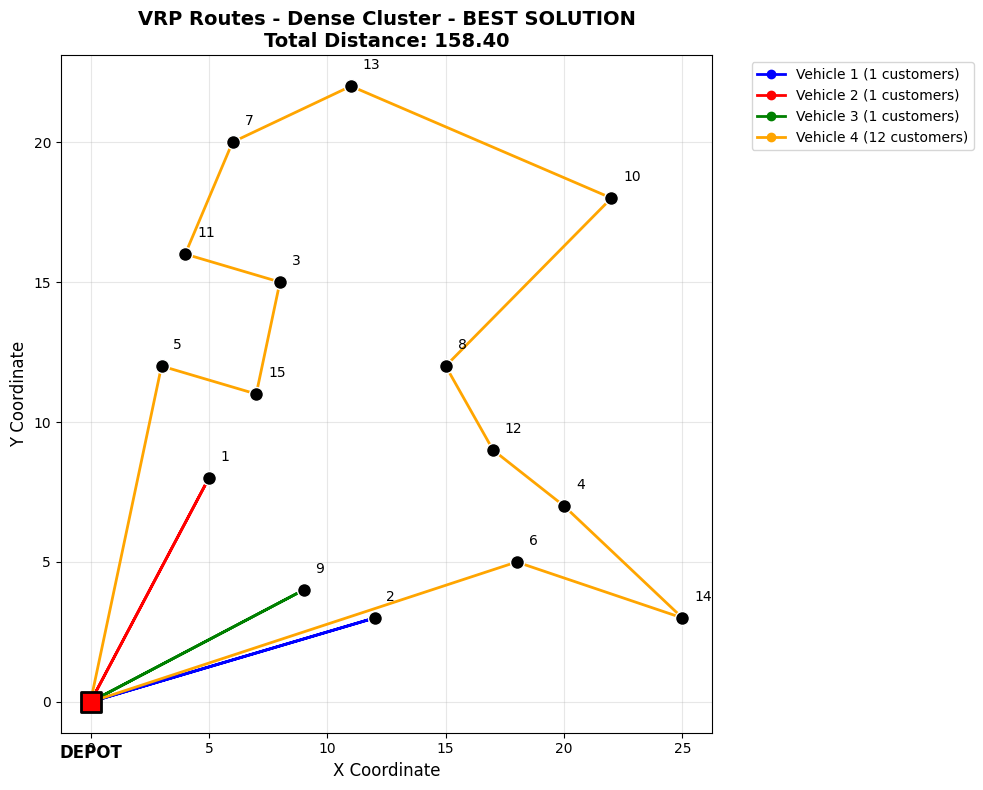


BEST SOLUTION FOR SPREAD PATTERN
Distance: 233.00 units
Parameter Set: set_2 (Balanced)
Trials: 10 (Avg: 248.66)
Routes:
Vehicle 1: 0 -> 5 -> 10 -> 18 -> 13 -> 3 -> 16 -> 2 -> 14 -> 7 -> 17 -> 12 -> 4 -> 9 -> 0
    Vehicle 2: 0 -> 1 -> 0
    Vehicle 3: 0 -> 15 -> 0
    Vehicle 4: 0 -> 8 -> 0
    Vehicle 5: 0 -> 6 -> 0
    Vehicle 6: 0 -> 11 -> 0


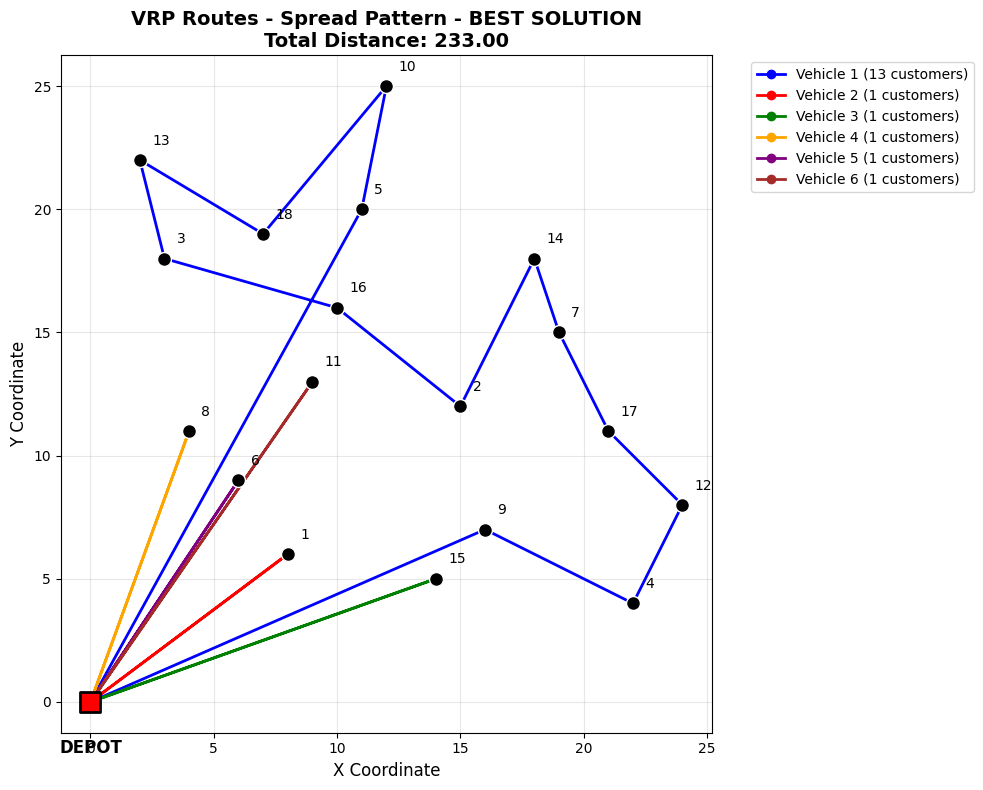

In [21]:
# VISUALIZE BEST GENETIC ALGORITHM RESULTS
# This will show the optimized routes found by your GA experiments

# Check if results exist from the main experiment
try:
    # Try to plot the best solutions from your experiments
    plot_best_solutions(results)
except NameError:
    print("ERROR: 'results' not found. You need to run the main experiment first!")
    print("Go back and run the 'EXECUTE FULL EXPERIMENT' cell first, then come back here.")
    print()
    print("Alternatively, here's a demo plot with a random solution:")
    print("-" * 50)
    
    # Create a demo plot to show that visualization works
    demo_individual = create_individual(SCENARIOS[0])  # Dense Cluster scenario
    print(f"Demo solution for {SCENARIOS[0]['name']}:")
    print(f"Routes: {visualize_routes(demo_individual)}")
    print(f"Total distance: {calculate_total_distance(demo_individual, SCENARIOS[0]['locations']):.2f}")
    
    # Plot the demo
    plot_vrp_routes(demo_individual, SCENARIOS[0]['locations'], f"{SCENARIOS[0]['name']} - Random Demo")